# Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Import the data

In [3]:
data = pd.read_csv('data.csv')

In [4]:
total_rows = data.shape[0]
viral_load = data["y"]
LOQ = data["cens"]
LOQ_list = []
for a in range(total_rows):
    if LOQ[a] == 1:
        LOQ_list.append(viral_load[a])


In [5]:
ID = data["ID"]
data["time_symptoms"] = data["time_monolix"] - 14
time = data["time_symptoms"]
ty = data["type"] 
age = data["age_cat_cov"]
sex = data["sex"]

## Patient: [viral load list]

In [6]:
dic_vl = {}
current_list = []

for i in range(total_rows):
    if i != total_rows - 1:
        current_ID = ID[i]
        if ty[i] != 2:
            current_list.append(viral_load[i])
        next_ID = ID[i+1]
        if next_ID != current_ID:
            dic_vl.update({i:current_list}) ## key: last row of the patient
            current_list = []
    else:
        if ty[i] != 2:
            current_list.append(viral_load[i])
        dic_vl.update({i:current_list})

## Patient: [time list]

In [7]:
dic_time = {}
current_list = []

for a in range(total_rows):
    if a != total_rows - 1:
        current_ID = ID[a]
        if ty[a] != 2:
            current_list.append(time[a])
        next_ID = ID[a+1]
        if next_ID != current_ID:
            dic_time.update({a:current_list}) 
            current_list = []
    else:
        if ty[a] != 2:
            current_list.append(time[i])
        dic_time.update({a:current_list})

## Classification according to age

In [8]:
dic_un65_time = {} ## under 65y
dic_lar65_time = {} ## larger 65y
dic_un65_vl = {}
dic_lar65_vl = {}
for c in dic_time.keys(): ## last row of the patient
    if age[c] == 1:
        dic_un65_time.update({c:dic_time[c]})
        dic_un65_vl.update({c:dic_vl[c]})
    else:
        dic_lar65_time.update({c:dic_time[c]})
        dic_lar65_vl.update({c:dic_vl[c]})

## Classification according to sex

In [9]:
dic_male_time = {}
dic_female_time = {}
dic_male_vl = {}
dic_female_vl = {}
for d in dic_time.keys(): ## last row of the patient
    if sex[d] == 0:
        dic_male_time.update({d:dic_time[d]})
        dic_male_vl.update({d:dic_vl[d]})
    else:
        dic_female_time.update({d:dic_time[d]})
        dic_female_vl.update({d:dic_vl[d]})

## More than 4 serial samples (non-thereshold) were aviliable

### Function of making new dictionaries

In [92]:
def valid_patients(dic_time,dic_vl):
    new_dic_time = {}
    new_dic_vl = {}
    for w in dic_time.keys(): ## last row of the patient
        count = 0
        time_list = dic_time[w]
        vl_list = dic_vl[w]
        for q in range(len(vl_list)): ## the time list
            viral_load = vl_list[q]
            if viral_load not in LOQ_list: ## after 14 days
                count += 1
        if count >= 5:
            new_dic_time.update({w:dic_time[w]})
            new_dic_vl.update({w:dic_vl[w]})
    return new_dic_time,new_dic_vl

### According to age

In [93]:
dic_un65_4_time, dic_un65_4_vl = valid_patients(dic_un65_time,dic_un65_vl)
dic_lar65_4_time, dic_lar65_4_vl = valid_patients(dic_lar65_time,dic_lar65_vl)

In [94]:
len(dic_un65_4_time.keys())+len(dic_lar65_4_time.keys()) ## = 30 patients 

10

In [105]:
dic_lar65_4_time

{373: [7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 20.0, 22.0, 23.0],
 415: [0.0, 3.0, 5.0, 6.0, 7.0, 12.0],
 447: [7.0, 9.0, 10.0, 12.0, 15.0],
 1137: [7.0, 9.0, 12.0, 20.0, 28.0, 36.0, 49.0],
 2030: [6.0, 7.0, 9.0, 13.0, 14.0, 16.0, 18.0, 19.0]}

### According to sex

In [67]:
dic_male_4_time, dic_male_4_vl = valid_patients(dic_male_time,dic_male_vl)
dic_female_4_time, dic_female_4_vl = valid_patients(dic_female_time,dic_female_vl)

In [68]:
len(dic_male_4_time.keys())+len(dic_female_4_time.keys()) ## = 30 patients 

10

# Data fitting

## Functions

### Define the viral load functions

In [69]:
def v_1(t, a1, a2, logVmax):
    return 1. + (10**logVmax - 1.0)*(tanh(6.0*(t - (a1 + a2)/2)/abs(a2 - a1)) - tanh(-3.0*(a2 + a1)/abs(a2 - a1)))/2

def v_3(t, b1, b2):
    return 1. - (1.0 - 1e-7)*(tanh(6.0*(t - (b1 + b2)/2)/abs(b2 - b1)) - tanh(-3.0*(b2 + b1)/abs(b2 - b1)))/2

In [70]:
def H(x):
    return 0.5*(tanh(1e3*x) + 1.)
def v_2(a2,a,t): 
    return 1. - H(t - a2) + H(t - a2)*exp(-a*(t - a2))

In [71]:
def func(x,logVmax,a1,a2,a,b1,b2):
    viral_load = v_1(x, a1, a2, logVmax)*v_2(a2,a,x)*v_3(x, b1, b2)
    return log10(viral_load)

In [72]:
def effective(X,logVmax,a1,a2,a,b1,b2):
    result = []
    x,threshold = X
    thereshold_num = threshold[0]
    for i in func(x,logVmax,a1,a2,a,b1,b2):
        result.append(max(i,thereshold_num))
    return array(result)

### Functions of patient information

In [73]:
def patient(i,dic_time,dic_vl): ## patient NO.i; return patientID, time(list), viral load(list)
    patient_ID = list(dic_time.keys())[i]
    vl_ori = dic_vl[patient_ID]
    t_ori = dic_time[patient_ID]
    vl = vl_ori.copy()
    t = t_ori.copy()
    return patient_ID,t,vl
    
def threshold_fun(t,vl): ## return the threshold(array) of the patient
    threshold_num = min(vl)
    if threshold_num not in LOQ_list:
        threshold_num == 0
        t.append(max(t)+5)
        vl.append(0)
        t.insert(0,0)
        vl.insert(0,0)
    else:
        t.insert(0,0)
        vl.insert(0,threshold_num)
        if vl[-1] != threshold_num:
            t.append(max(t)+5)
            vl.append(threshold_num)
    thr = list(zeros(len(t)) + threshold_num)
    return array(thr)

### Function of getting the best parameters

In [86]:
def best_pa(effective,t,vl,thr): ## dictionaries
    
    ##np.random.seed(1857)
    tmax = max(t) ## upper bound
    best_rss = 1000 ## initial rss
    best_pa = [] ## initial best parameters    

    ##step1: set the initial guesses 
    n = 1000
    for count in range(n):
        guess = np.sort(tmax*np.random.rand(4)) ### initial guess
    
        ##step2:curvefit
        try:
            popt, pcov = curve_fit(effective,(array(t),thr),array(vl),[max(vl),guess[0],guess[1],0.2,guess[2],guess[3]],bounds=(0,[2*max(vl),max(t),max(t),1e2, max(t),max(t)]))
            
            #step3: find the best parameters
            if 0<popt[1]<popt[2]<popt[4]<popt[5] and 0<popt[3] and 0<popt[0]:
                current_rss = sum((effective((t,thr),*popt)-vl)**2)
                if current_rss <= best_rss:
                    best_rss = current_rss
                    best_pa = popt
       
        except TypeError:
            #number = 6-len(vl)
            #for i in range(number):
                #t.append(max(t)+5)
                #vl.append(thr)
            pass
        except RuntimeError:
            pass
        except ValueError:
            pass
    
        
    return best_pa,best_rss
    

### Function of plots

In [87]:
def dic_fitted_curve(t,vl,parameters,colour): ## fitted cureve: red; 
                                              ## dots: 1.blue: < 65 or male; 
                                              ##       2.green: added points for threshld
                                              ##       3.orange: >65 or female
                                              ## triangles: LOQ
    
    ##step1: plot the data points
    for x in range(1,len(vl)-1):
            if vl[x] in LOQ_list:
                plt.plot(time[x],vl[x],"^",color="black",label="LOQ")
            else:
                plt.plot(t[x],vl[x],"o",color = "black",label="original data")
    plt.plot(t[0], vl[0], 'o',color = "green",label="added data")
    if vl[-1] == 0:
        plt.plot(t[-1], vl[-1], 'o',color = "green")
    
    ##step2: plot the fitted curve
    t0 = np.linspace(0,35,100)
    plt.plot(t0, func(t0,*parameters), color = colour,label="fitted Curve")
    
    ##step3: set the format of the figure
    plt.xlim(-5,35)
    plt.ylim(0,15)

### Function of checking the parameters and residual sum for squares

In [88]:
def check(i,dic): ## patientID
    best = dic[i]
    parameters = best[0]
    rss = best[1]
    print("The parameters for patient",i,"are: ",parameters)
    print("The residual sum of squares of patient",i,"is:",rss )

# Intervals

## Functions for plotting the interval

In [89]:
import time
import sys

def max_min(pa,rss,t,vl,thr,colour):

    ##np.random.seed(1857)
    t0 = np.linspace(0,35,100)

    best_VMax, best_a1, best_a2, best_a, best_b1, best_b2 = pa[0], pa[1], pa[2], pa[3], pa[4], pa[5]
    y = func(t0,*pa)

    fmax = list(y)
    fmin = list(y)
    
    list_VMax = []
    list_a1 = []
    list_a2 = []
    list_a = []
    list_b1 = []
    list_b2 = []
    
    found = 0
    n = 1000

    # setup toolbar
    sys.stdout.write("[%s]" % (" " * n))
    sys.stdout.flush()
    sys.stdout.write("\b" * (n+1)) # return to start of line, after '['


    for count in range(n):

        VMax = np.random.normal(best_VMax,0.5)
        a1 = np.random.normal(best_a1,1.1)
        a2 = np.random.normal(best_a2,1.1)
        a = np.random.normal(best_a,0.5)
        b1 = np.random.normal(best_b1,1.1)
        b2 = np.random.normal(best_b2,1.1)

        current_pa = [VMax,a1,a2,a,b1,b2]
        current_y = list(func(t0,*current_pa))
        current_rss = sum((effective((t,thr),*current_pa)-vl)**2) 
        
        if current_rss <= (1.2*rss) and 0<a1<a2<b1<b2 and 0<a and 0<VMax :
            found += 1
            fmax = list(map(max, zip(fmax, current_y)))
            fmin = list(map(min, zip(fmin, current_y)))
            
            list_VMax.append(VMax)
            list_a1.append(a1)
            list_a2.append(a2)
            list_a.append(a)
            list_b1.append(b1)
            list_b2.append(b2)
            
    print(str(found) + ' out of ' + str(n))

    fill_between(t0, fmax, fmin, color = colour )
    
    if len(list_a1)>0:
        
        range_a1 = (min(list_a1),max(list_a1))
        range_a2 = (min(list_a2),max(list_a2))
        range_a = (min(list_a),max(list_a))
        range_b1 = (min(list_b1),max(list_b1))
        range_b2 = (min(list_b2),max(list_b2))
        range_VMax = (min(list_VMax),max(list_VMax))
        return [range_VMax,range_a1,range_a2,range_a,range_b1,range_b2]
    
    else:
        return [0,0,0,0,0,0]


In [90]:
def check_range(i): ## patientID
    pa_range = dic_pa_range[i]
    Vmax,a1,a2,a,b1,b2 = pa_range[0], pa_range[1],pa_range[2],pa_range[3],pa_range[4],pa_range[5]
    print("The range of VMax for patient",i,"is: ",Vmax)
    print("The range of a1 for patient",i,"is: ",a1)
    print("The range of a2 for patient",i,"is: ",a2)
    print("The range of a for patient",i,"is: ",a)
    print("The range of b1 for patient",i,"is: ",b1)
    print("The range of b2 for patient",i,"is: ",b2)

52 out of 1000
25 out of 1000
0 out of 1000
677 out of 1000
220 out of 1000
1 out of 1000
119 out of 1000
227 out of 1000
17 out of 1000
71 out of 1000


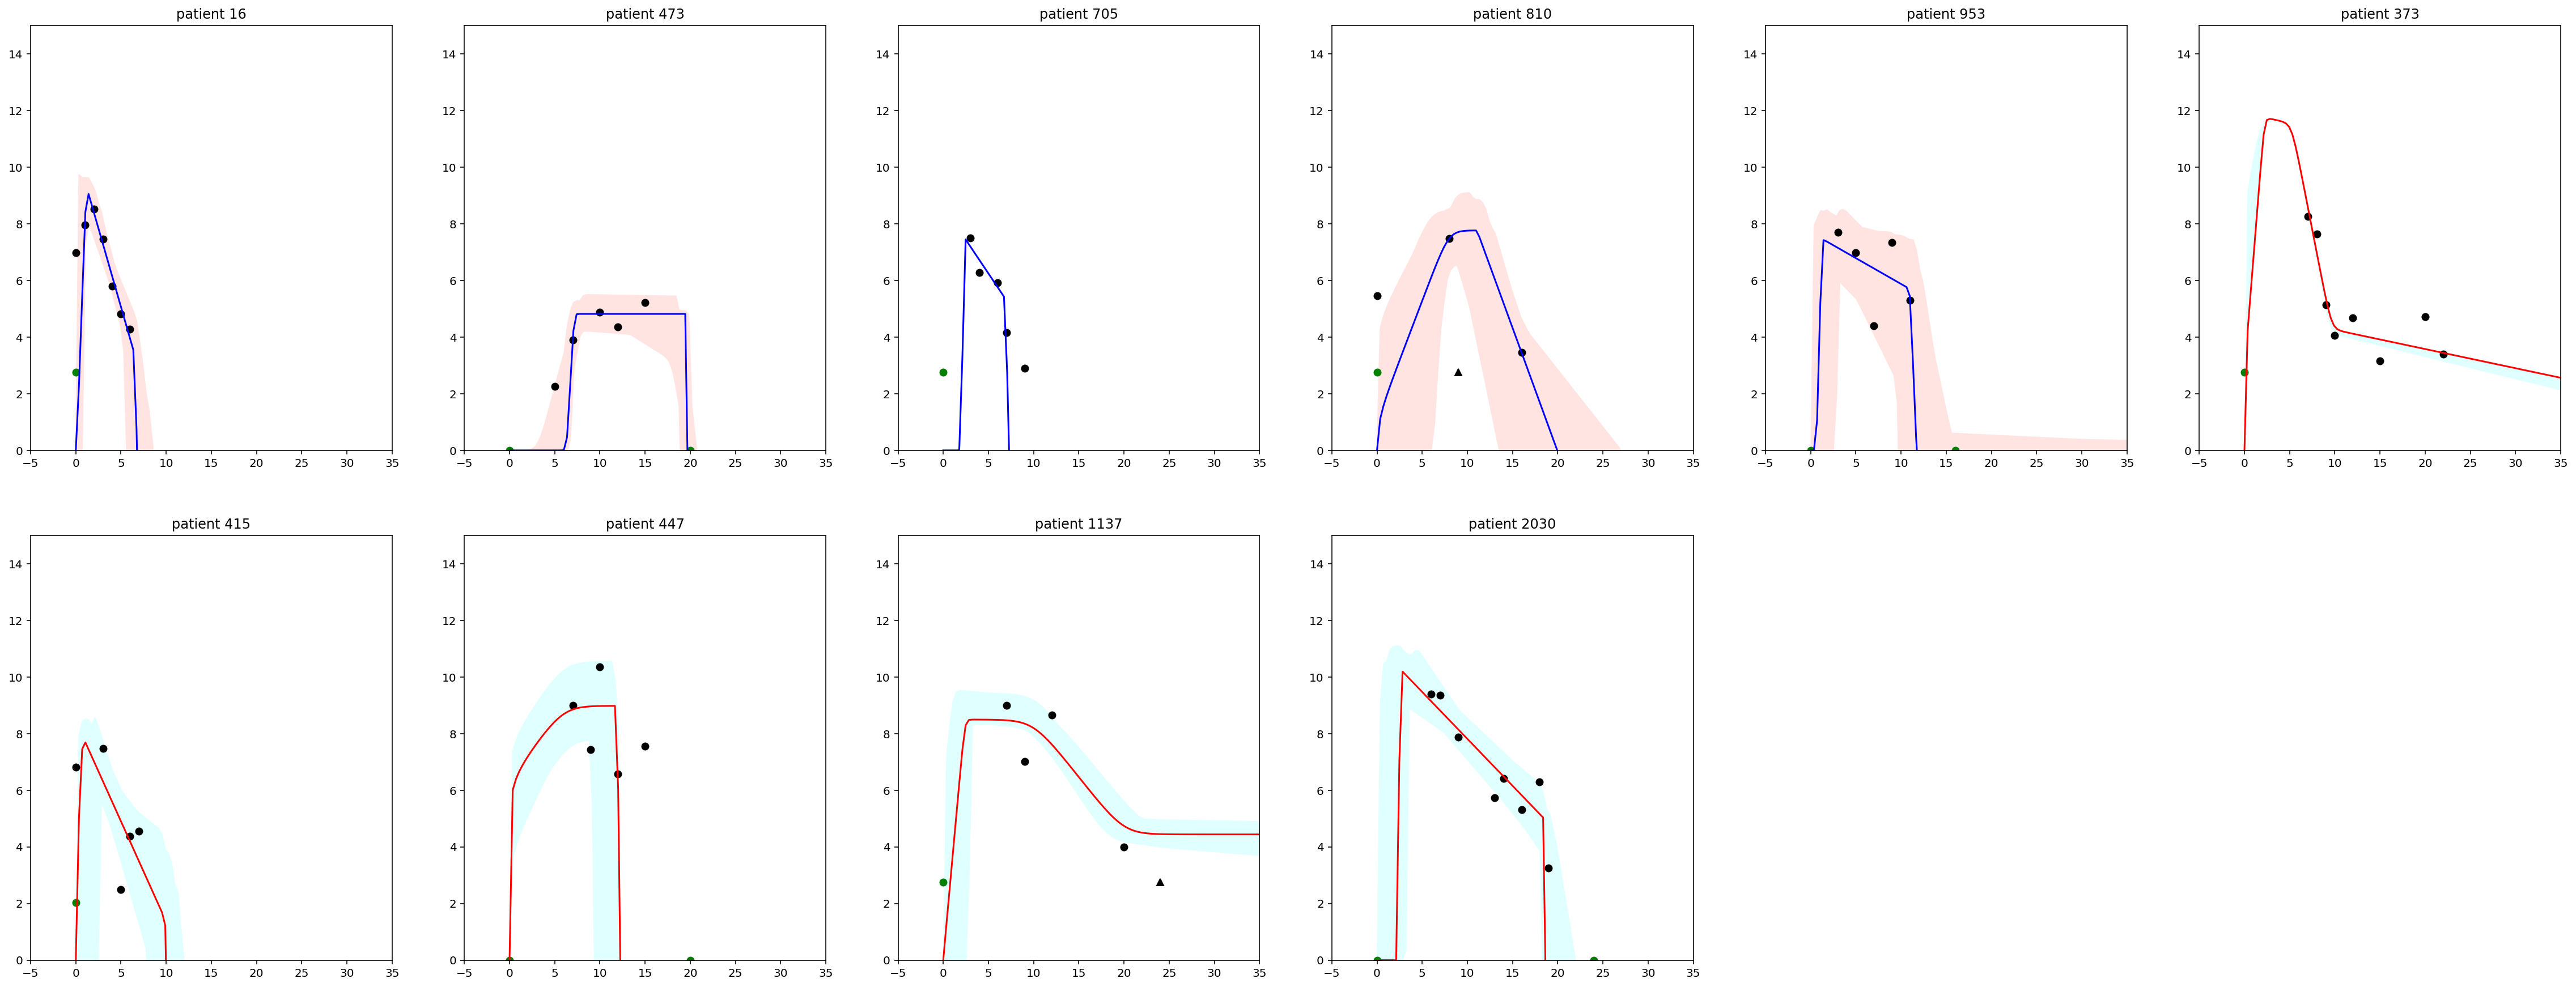

In [91]:
plt.rcParams['figure.figsize'] = [40,40]

dic_pa_age = {}
dic_pa_range = {}

for j in range (1,len(dic_un65_4_time.keys())+1):
# for j in range (1,7):
    
    plt.subplot(5,6,j)
    
    ## patientID, time, viral load, threshold, best parameters & rss
    patient_ID,t,vl = patient(j-1,dic_un65_4_time,dic_un65_4_vl)
    thr = threshold_fun(t,vl)
    parameters,rss = best_pa(effective,t,vl,thr)
    dic_pa_age.update({patient_ID:[parameters,rss]})
    dic_fitted_curve(t,vl,parameters,"blue")
    pa_range = max_min(parameters,rss,array(t),array(vl),thr,"mistyrose")
    dic_pa_range.update({patient_ID:pa_range})
    
    ## legend
    plt.subplot(5,6,j).set_title('patient ' + str(patient_ID))
    


for k in range (len(dic_un65_4_time.keys())+1,len(dic_un65_4_time.keys())+len(dic_lar65_4_time.keys())+1):
    
    plt.subplot(5,6,k)
    number = k-len(dic_un65_4_time.keys())-1
    
    ## patientID, time, viral load, threshold, best parameters & rss
    patient_ID,t,vl = patient(number,dic_lar65_4_time,dic_lar65_4_vl)
    thr = threshold_fun(t,vl)
    parameters,rss = best_pa(effective,t,vl,thr)
    dic_pa_age.update({patient_ID:[parameters,rss]})
    dic_fitted_curve(t,vl,parameters,"red")
    pa_range = max_min(parameters,rss,array(t),array(vl),thr,"lightcyan")
    dic_pa_range.update({patient_ID:pa_range})
    ## legend
    plt.subplot(5,6,k).set_title('patient ' + str(patient_ID))
    
#plt.legend()
plt.show()


In [30]:
check_range(903)
check(903,dic_pa_age)

The range of VMax for patient 903 is:  (13.179007744748382, 15.19452449827644)
The range of a1 for patient 903 is:  (0.37388292061388145, 2.9655362132461303)
The range of a2 for patient 903 is:  (2.3722870189046334, 5.260728206252424)
The range of a for patient 903 is:  (0.4641981589367284, 1.747440219236729)
The range of b1 for patient 903 is:  (3.2808570015309044, 6.610477440193638)
The range of b2 for patient 903 is:  (6.678220921276619, 8.922768663592459)
The parameters for patient 903 are:  [14.00594059  0.72028352  4.34858091  0.62523825  4.64447277  7.33544013]
The residual sum of squares of patient 903 is: 24.885721563804005


In [26]:
check_range(454)
check(454,dic_pa_age)

The range of VMax for patient 454 is:  0
The range of a1 for patient 454 is:  0
The range of a2 for patient 454 is:  0
The range of a for patient 454 is:  0
The range of b1 for patient 454 is:  0
The range of b2 for patient 454 is:  0
The parameters for patient 454 are:  [ 7.49389046  5.38257808 10.92241676 64.98402126 11.1990081  13.7626338 ]
The residual sum of squares of patient 454 is: 1.4622607505576228


In [27]:
check_range(679)
check(679,dic_pa_age)

The range of VMax for patient 679 is:  0
The range of a1 for patient 679 is:  0
The range of a2 for patient 679 is:  0
The range of a for patient 679 is:  0
The range of b1 for patient 679 is:  0
The range of b2 for patient 679 is:  0
The parameters for patient 679 are:  [ 4.38199642  0.74036966  2.10629368  0.26105714 13.8375902  13.9869133 ]
The residual sum of squares of patient 679 is: 1.1375080632432426


In [28]:
check_range(1114)
check(1114,dic_pa_age)

The range of VMax for patient 1114 is:  0
The range of a1 for patient 1114 is:  0
The range of a2 for patient 1114 is:  0
The range of a for patient 1114 is:  0
The range of b1 for patient 1114 is:  0
The range of b2 for patient 1114 is:  0
The parameters for patient 1114 are:  [11.80570857  0.44895158  4.78776726  2.16197149 15.79387176 29.43251708]
The residual sum of squares of patient 1114 is: 0.018613459236047014


In [38]:
check(556,dic_pa_age)

The parameters for patient 556 are:  [12.75662561  3.16084149  7.46496566  0.53267698  7.98087089 10.61225918]
The residual sum of squares of patient 556 is: 20.936392081474178
